In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

## 1. 모델 구성하기

In [10]:
data = pd.read_csv('./TrafficData/4-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 360

In [11]:
from torch import FloatTensor as FloatTensor

In [12]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [13]:
split = 10080
x_train,y_train = seq_data(data.iloc[:-split],sequence_length,pred_len)

In [14]:
x_train.size()

torch.Size([27000, 1, 1440])

In [15]:
batch_size = 64
train_dataset = TensorDataset(x_train,y_train)
training = DataLoader(train_dataset,batch_size= batch_size)

In [16]:
seed = 42

In [17]:
device = torch.device("cuda:0")

In [25]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [19]:
target = list(data.iloc[-split:-split+pred_len].values)
target = FloatTensor(target).view(-1,1)
target

tensor([[ 90520.],
        [ 89814.],
        [ 86395.],
        [ 89065.],
        [ 85193.],
        [ 87391.],
        [ 85609.],
        [ 86244.],
        [ 84304.],
        [ 86815.],
        [ 83618.],
        [ 86064.],
        [ 82244.],
        [ 84805.],
        [ 82272.],
        [ 83415.],
        [ 80693.],
        [ 81802.],
        [ 81619.],
        [ 82033.],
        [ 81861.],
        [ 78951.],
        [ 81576.],
        [ 78467.],
        [ 80895.],
        [ 76625.],
        [ 80614.],
        [ 77921.],
        [ 81156.],
        [ 76667.],
        [ 80052.],
        [ 74750.],
        [ 78297.],
        [ 73855.],
        [ 77834.],
        [ 73881.],
        [ 77449.],
        [ 72496.],
        [ 76311.],
        [ 70855.],
        [ 77667.],
        [ 72778.],
        [ 78441.],
        [ 72819.],
        [ 76707.],
        [ 70612.],
        [ 76230.],
        [ 70458.],
        [ 76259.],
        [ 69757.],
        [ 75257.],
        [ 68427.],
        [ 73

In [45]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_len = 1440
        self.pred_len = 360
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.weight_df = pd.DataFrame({"weight":self.first_layer.weight.cpu().detach().numpy().reshape(-1)})
        # weight update를 위한 데이터프레임 이를 사용해야지 인덱스가 바뀌는 문제를 고정된 인덱스로 해결 가능
    def forward(self,x):
        return self.first_layer(x).squeeze(1)

weight를 뽑으면 순서대로 정렬 돼있을거임 

In [46]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [47]:
n = len(training)

In [48]:
X_test.size()

torch.Size([1, 1, 1440])

### Full-Trained Model(M) 구성

In [49]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs,labels.squeeze(1))
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 45.288
Epoch [21]/[100] running accumulative loss across all batches: 41.225
Epoch [41]/[100] running accumulative loss across all batches: 41.142
Epoch [61]/[100] running accumulative loss across all batches: 41.076
Epoch [81]/[100] running accumulative loss across all batches: 40.299


In [50]:
pred = model(X_test)
pred= pred.cpu().detach().view(-1,1)
result = criterion(pred,target).item()*100
result

88.24793696403503

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
X_test.size()

torch.Size([1, 1, 1440])

In [53]:
model

Model(
  (first_layer): Linear(in_features=1440, out_features=360, bias=True)
)

In [95]:
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_test = nt_ig.attribute(X_test,target=0)
# 여러개의 output이 있으므로 어떤 target에 대해서 attribution을 구할것인지 명시해야한다.
# 이때 아래에서 리스트로 전달해도 된다는 것의 의미는 예제의 갯수에 맞게 그러니깐 X_test의 sample갯수에 맞게 리스트를 입력하면 된다.
# 결론적으로, 하나의 결과에 대해서만 계산할 수 있다.
nt_ig_attr_test

tensor([[[ 737.0080,  609.1163,  610.5202,  ..., 1768.5806, 2447.4512,
          1917.9781]]], device='cuda:0', dtype=torch.float64)

### Q> Multiple output을 낼때의 각 output마다 attribution의 경향이 다를까?

In [96]:
attr_df = pd.DataFrame({"attr":nt_ig_attr_test.cpu().numpy().reshape(-1)})
attr_df

,attr
0,737.007951
1,609.116284
2,610.520209
3,590.682109
4,590.196765
...,...
1435,1716.412687
1436,2310.677985
1437,1768.580634
1438,2447.451199


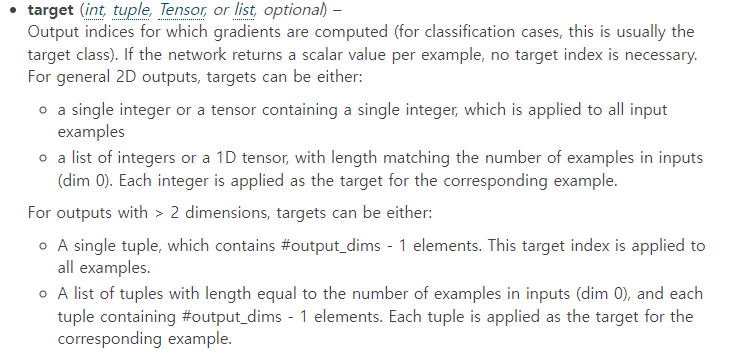

### A) plot을 찍어봄으로써 확인해보자

<AxesSubplot: >

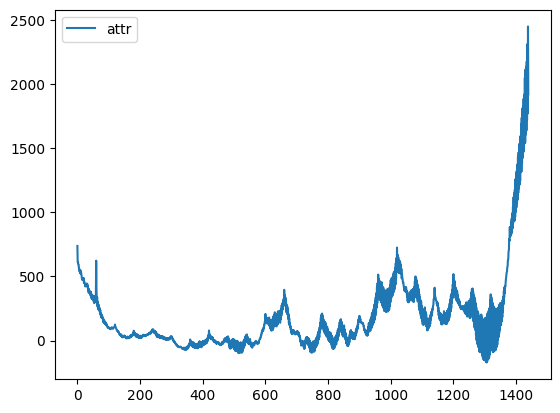

In [97]:
attr_df.plot()

### A2) 여러개의 output에 대한 attribution을 평균을 내서 확인

In [99]:
nt_ig_attr_test = torch.zeros((1,1,1))
for i in range(360):
    ig = IntegratedGradients(model)
    nt_ig = NoiseTunnel(ig)
    nt_ig_attr_test = nt_ig.attribute(X_test,target=i)
    nt_ig_attr_test+=nt_ig_attr_test
nt_ig_attr_test = nt_ig_attr_test/360
attr_df = pd.DataFrame({"attr":nt_ig_attr_test.cpu().numpy().reshape(-1)})

In [100]:
attr_df

,attr
0,6.262665
1,5.756770
2,5.704384
3,5.393598
4,5.338710
...,...
1435,-3.434742
1436,-3.171979
1437,-3.447606
1438,-3.273055


<AxesSubplot: >

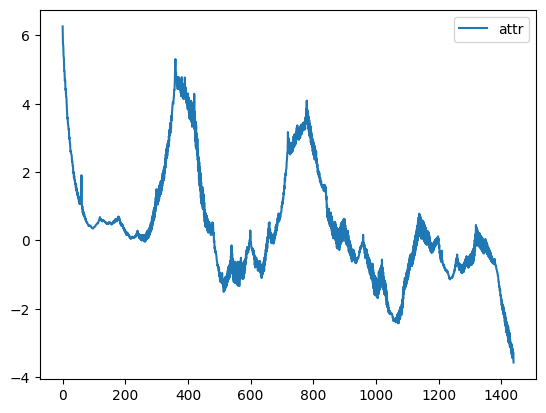

In [101]:
attr_df.plot()

<AxesSubplot: >

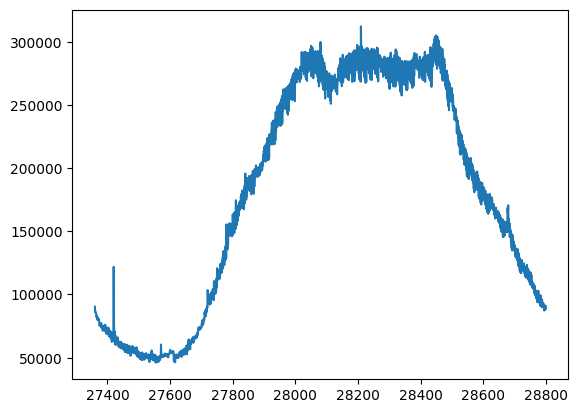

In [105]:
data.iloc[-split-sequence_length:-split].plot() #X_test값의 plot

## Trouble1 X_test의 값에 따라서 gradient가 작용하는 바가 다르기 때문에 평균을 취하게 되면 attribution이 상쇄되게 된다.